In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from scipy import ndimage
from six.moves import cPickle as pickle
import tensorflow as tf
import argparse


#pickle_file = 'train7d10class10000.pickle'
#pickle_file = 'brSimpleclass30.pickle'
pickle_file = 'train10step7Domain10000.pickle'

# Basic model parameters as external flags.
FLAGS = None


# Randomizing again the dataset
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, FLAGS.image_size, FLAGS.image_size, FLAGS.num_channels)).astype(np.float32)
  labels = (np.arange(FLAGS.num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels


def main(_):
  try:
    pickle_file
    print ("pickle file exists!")
    with open(pickle_file, 'rb') as f:
      save = pickle.load(f)
      train_dataset = save['train_dataset']
      train_labels = save['train_labels']
      test_dataset = save['test_dataset']
      test_labels = save['test_labels']
      del save  # hint to help gc free up memory
      print('Training set', train_dataset.shape, train_labels.shape)
      print('Test set', test_dataset.shape, test_labels.shape)
  except NameError:
    print ("pickle file does not exist!")

  # randomize the data
  train_dataset, train_labels = randomize(train_dataset, train_labels)
  test_dataset, test_labels = randomize(test_dataset, test_labels)
  print('Randomizing is done')
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)


  # Reformat the data: image data as a cube (width by height by number 
  # of channels) and labels as float 1-hot encodings.
  train_dataset, train_labels = reformat(train_dataset, train_labels)
  test_dataset, test_labels = reformat(test_dataset, test_labels)
  print('Reformatted training set', train_dataset.shape, train_labels.shape)
  print('Reformatted test set', test_dataset.shape, test_labels.shape)

  def accuracy(predictions, labels): 
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
  def accuracy2(predictions, labels):
    print ('shape = ', np.argmax(predictions, 1).shape)
    sh = np.argmax(predictions, 1).shape
    predArg = np.argmax(predictions, 1)
    labArg = np.argmax(labels, 1)  
    count = 0
    pred = []
    lab = []
    print ('sh[0]', sh[0])
    
    for i in range(sh[0]):
      #print (i)
      if predArg[i] != labArg[i]:
        count = count + 1
        #print ('pred = ', predArg[i])
        #print ('lab = ', labArg[i]) 
        pred.append(predArg[i])
        lab.append(labArg[i])
        #print ('prediction =', predictions[i,:])
        #print ('labels =', labels[i,:])  
    print ('count =', count)  
    print ('pred =', pred)
    print ('lab =', lab)
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

  def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
	                  strides=[1, 2, 2, 1], padding='SAME')

  def drop_out(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)

  graph = tf.Graph()

  with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(
      tf.float32, shape=(FLAGS.batch_size, FLAGS.image_size, FLAGS.image_size, FLAGS.num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(FLAGS.batch_size, FLAGS.num_labels))
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    W_conv1 = weight_variable([5, 5, 1, 20])
    b_conv1 = bias_variable([20])

    W_conv2 = weight_variable([5, 5, 20, 50])
    b_conv2 = bias_variable([50])

    W_fc1 = weight_variable([7 * 7 * 50, 500])
    b_fc1 = bias_variable([500])

    W_fc2 = weight_variable([500, FLAGS.num_labels])
    b_fc2 = bias_variable([FLAGS.num_labels])

  
    # Model.
    def model(data):
      h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
      h_pool1 = max_pool_2x2(h_conv1)
      h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
      h_pool2 = max_pool_2x2(h_conv2)
      shape = h_pool2.get_shape().as_list()
      reshape = tf.reshape(h_pool2, [shape[0], shape[1] * shape[2] * shape[3]])
      h_fc1 = tf.nn.tanh(tf.matmul(reshape, W_fc1) + b_fc1)
      return tf.matmul(h_fc1, W_fc2) + b_fc2
   
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

    step_plot = []
    loss_plot = []
    accuracy_plot = []

    init = tf.global_variables_initializer()

    # Create a session for running Ops on the Graph.
    sess = tf.Session()

    # Run the Op to initialize the variables.
    sess.run(init)

    print('Initialized')
    for step in range(FLAGS.max_steps):
      offset = (step * FLAGS.batch_size) % (train_labels.shape[0] - FLAGS.batch_size)
      batch_data = train_dataset[offset:(offset + FLAGS.batch_size), :, :, :]
      batch_labels = train_labels[offset:(offset + FLAGS.batch_size), :]
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = sess.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 50 == 0):
        print('Minibatch loss at step %d: %f' % (step, l))
        acc = accuracy(predictions, batch_labels)
        print('Minibatch accuracy: %.1f%%' % acc)
        step_plot.append(step)
        loss_plot.append(l)
        accuracy_plot.append(acc)
    print('Test accuracy: %.1f%%' % accuracy2(test_prediction.eval(session=sess), test_labels))
    print (test_prediction.eval(session=sess).shape)
    plt.figure(facecolor='white')
    plt.plot(step_plot, loss_plot, 'rs--')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Loss plot')
    plt.grid(True)
    plt.show()
    plt.figure(facecolor='white')
    plt.plot(step_plot, accuracy_plot, '--bs')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Accuracy plot')
    plt.grid(True)
    plt.show()
    #print(accuracy_plot)


if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument(
      '--learning_rate',
      type=float,
      default=0.005,
      help='Initial learning rate.'
  )
  parser.add_argument(
      '--max_steps',
      type=int,
      default=1001,
      help='Number of steps to run trainer.'
  )
  parser.add_argument(
      '--batch_size',
      type=int,
      default=100,
      help='Batch size.  Must divide evenly into the dataset sizes.'
  )
  parser.add_argument(
      '--number_classses',
      type=int,
      default=256,
      help='Number of classes in train and test data sets.'
  )
  parser.add_argument(
      '--image_size',
      type=int,
      default=28,
      help='Size of the image.'
  )
  parser.add_argument(
      '--pixel_depth',
      type=float,
      default=255.0,
      help='Number of levels per pixel.'
  )
  parser.add_argument(
      '--num_channels',
      type=int,
      default=1,
      help='1 for grayscale'
  )
  parser.add_argument(
      '--num_images_Train',
      type=int,
      default=10000,
      help='Number of images per label in train floder'
  )
  parser.add_argument(
      '--num_images_Test',
      type=int,
      default=100,
      help='Number of images per label in test floder'
  )
  parser.add_argument(
      '--num_labels',
      type=int,
      default=26,
      help='Number of labels'
  )

 
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)
  



pickle file exists!
Training set (260000, 28, 28) (260000,)
Test set (2600, 28, 28) (2600,)
Randomizing is done
Training set (260000, 28, 28) (260000,)
Test set (2600, 28, 28) (2600,)
Reformatted training set (260000, 28, 28, 1) (260000, 26)
Reformatted test set (2600, 28, 28, 1) (2600, 26)


In [2]:
train_filename = 'train7d10class10000'
test_filename = 'test7d10class10000'

In [3]:
# extracting the datasets
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

train7d10class10000 already present - Skipping extraction of train7d10class10000.
['train7d10class10000/0', 'train7d10class10000/105', 'train7d10class10000/135', 'train7d10class10000/15', 'train7d10class10000/165', 'train7d10class10000/195', 'train7d10class10000/225', 'train7d10class10000/255', 'train7d10class10000/45', 'train7d10class10000/75']
test7d10class10000 already present - Skipping extraction of test7d10class10000.
['test7d10class10000/0', 'test7d10class10000/105', 'test7d10class10000/135', 'test7d10class10000/15', 'test7d10class10000/165', 'test7d10class10000/195', 'test7d10class10000/225', 'test7d10class10000/255', 'test7d10class10000/45', 'test7d10class10000/75']


In [4]:
# have a look at data
import random
import hashlib

def disp_samples(data_folders, sample_size):
  for folder in data_folders:
    print(folder)
    image_files = os.listdir(folder)
    image_sample = random.sample(image_files, sample_size)
    for image in image_sample:
      image_file = os.path.join(folder, image)
      i = Image(filename=image_file)
      display(i)

In [5]:
disp_samples(train_folders, 1)

train7d10class10000/0


train7d10class10000/105


train7d10class10000/135


train7d10class10000/15


train7d10class10000/165


train7d10class10000/195


train7d10class10000/225


train7d10class10000/255


train7d10class10000/45


train7d10class10000/75


In [6]:
disp_samples(test_folders, 1)

test7d10class10000/0


test7d10class10000/105


test7d10class10000/135


test7d10class10000/15


test7d10class10000/165


test7d10class10000/195


test7d10class10000/225


test7d10class10000/255


test7d10class10000/45


test7d10class10000/75


In [7]:
#Merging the data

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
num_of_classes = 10

        
def Merge_folders(data_folders, size_per_class):
  dataset_names = []
  start_t = 0
  end_t = size_per_class
  required_size = size_per_class * num_of_classes
  trainDataset = np.ndarray((required_size, image_size, image_size), dtype=np.uint8)
  labelsDataset = np.ndarray(required_size, dtype=np.int32)
  for folder in data_folders:
    dataset_names.append(folder)

    print('Merging %s.' % folder)
    image_files = os.listdir(folder)
    np.random.shuffle(image_files)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.uint8)
    image_index = 0
    for image in image_files:
        if image_index < size_per_class:
            image_file = os.path.join(folder, image)
            image_data = (ndimage.imread(image_file).astype(int))
            dataset[image_index, :, :] = image_data
            image_index += 1
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    trainDataset[start_t:end_t, :, :] = dataset
    labelsDataset[start_t:end_t] = folder.split("/")[1]
    start_t += size_per_class
    end_t += size_per_class

  
  return dataset_names, trainDataset, labelsDataset

train_datasets, trainDataset, labelsTrainDataset = Merge_folders(train_folders, 10000)
test_datasets, testDataset, labelsTestDataset = Merge_folders(test_folders, 100)

print(trainDataset)
print(labelsTrainDataset)

print(testDataset)
print(labelsTestDataset)

print('trainDataset.shape' , trainDataset.shape)
print('labelsTrainDataset.shape' , labelsTrainDataset.shape)

print('testDataset.shape' , testDataset.shape)
print('labelsTestDataset.shape' , labelsTestDataset.shape)

Merging train7d10class10000/0.
Merging train7d10class10000/105.
Merging train7d10class10000/135.
Merging train7d10class10000/15.
Merging train7d10class10000/165.
Merging train7d10class10000/195.
Merging train7d10class10000/225.
Merging train7d10class10000/255.
Merging train7d10class10000/45.
Merging train7d10class10000/75.
Merging test7d10class10000/0.
Merging test7d10class10000/105.
Merging test7d10class10000/135.
Merging test7d10class10000/15.
Merging test7d10class10000/165.
Merging test7d10class10000/195.
Merging test7d10class10000/225.
Merging test7d10class10000/255.
Merging test7d10class10000/45.
Merging test7d10class10000/75.
[[[  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  ..., 
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]]

 [[  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  ..., 
  [  0   0   0 ...,   0   0   0]
  [  0   0  

12008
105


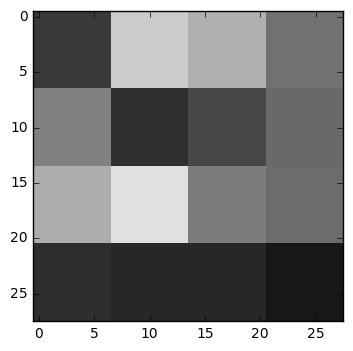

105.0

In [8]:
#test the data
rand_image = random.randint(0, 20000)
print (rand_image)
plt.imshow(trainDataset[rand_image], cmap='gray', interpolation='nearest', vmin=0, vmax=255)
print (labelsTrainDataset[rand_image])
plt.show()
np.mean(trainDataset[rand_image])

In [10]:
# randomize the data
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(trainDataset, labelsTrainDataset)
test_dataset, test_labels = randomize(testDataset, labelsTestDataset)

train_labels

array([255,   0,  75, ...,  75,   0, 195], dtype=int32)

10864
75


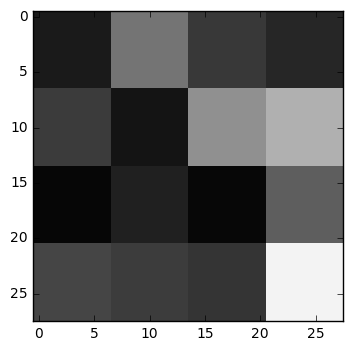

75.0

In [11]:
#test the data
rand_image = random.randint(0, 20000)
print (rand_image)
plt.imshow(train_dataset[rand_image], cmap='gray', interpolation='nearest', vmin=0, vmax=255)
print (train_labels[rand_image])
plt.show()
np.mean(train_dataset[rand_image])

116
0


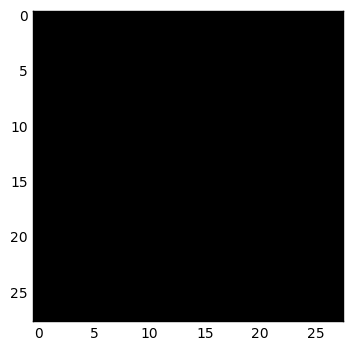

0.0

In [12]:
#test the data
rand_image = random.randint(0, 200)
print (rand_image)
plt.imshow(test_dataset[rand_image], cmap='gray', interpolation='nearest', vmin=0, vmax=255)
print (test_labels[rand_image])
plt.show()
np.mean(test_dataset[rand_image])

In [13]:
# save the data
pickle_file = 'train7d10class10000.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [14]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 79588342


In [15]:
#estimate the duplicates

all_data = pickle.load(open('train7d10class10000.pickle', 'rb'))

def count_duplicates(dataset1, dataset2):
    hashes = [hashlib.sha1(x).hexdigest() for x in dataset1]
    dup_indices = []
    for i in range(0, len(dataset2)):
        if hashlib.sha1(dataset2[i]).hexdigest() in hashes:
            dup_indices.append(i)
    return len(dup_indices)


print(count_duplicates(all_data['test_dataset'], all_data['train_dataset']))

20495


In [16]:
# test a regression model

train_dataset = all_data['train_dataset']
train_labels = all_data['train_labels']
test_dataset = all_data['test_dataset']
test_labels = all_data['test_labels']

print (len(train_dataset))
print (len(train_labels))
print (len(test_dataset))
print (len(test_labels))

100000
100000
1000
1000


In [17]:

def get_score(train_dataset, train_labels, test_dataset, test_labels):
    model = LogisticRegression()
    train_flatten_dataset = np.array([x.flatten() for x in train_dataset])
    test_flatten_dataset = np.array([x.flatten() for x in test_dataset])
    model.fit(train_flatten_dataset, train_labels)

    return model.score([x.flatten() for x in test_dataset], test_labels)

print("100 trainsamples score: " + str(get_score(train_dataset[:100], train_labels[:100], test_dataset, test_labels)))
print("1000 trainsamples score: " + str(get_score(train_dataset[:1000], train_labels[:1000], test_dataset, test_labels)))
print("5000 trainsamples score: " + str(get_score(train_dataset[:5000], train_labels[:5000], test_dataset, test_labels)))
print("100000 trainsamples score: " + str(get_score(train_dataset[:100000], train_labels[:100000], test_dataset, test_labels)))


100 trainsamples score: 0.326
1000 trainsamples score: 0.456
5000 trainsamples score: 0.524
100000 trainsamples score: 0.815
